In [16]:
import torch
from mymodel import MySemiModel
import cv2
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from albumentations import HorizontalFlip, VerticalFlip, Rotate, Compose
import numpy as np
import pandas as pd

In [3]:
model = MySemiModel()

In [4]:
model.load_state_dict(torch.load("./model.pth"))

<All keys matched successfully>

In [5]:
model.eval()

MySemiModel(
  (down): MyDown(
    (down1): DownModule(
      (contract1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (contract2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (down2): DownModule(
      (contract1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (contract2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (down3): DownModule(
      (contract1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (contract2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (flat): DownModule(
    (contract1): Conv2d(64, 128, kernel_size=(3, 3), stride

In [6]:
class TestCellDataset(Dataset):
    def __init__(self):
        self.test_path = "../data/test"
        
        # I am not sure if they adapt the sample submission csv or only the test folder
        # I am using the test folders as the ground truth for the images to predict, which should be always right
        # The sample csv is ignored
        self.image_ids = [f[:-4]for f in os.listdir(self.test_path)]
        self.num_samples = len(self.image_ids)
        self.transform = Compose([ToTensorV2()])

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        path = os.path.join(self.test_path, image_id + ".png")
        image = cv2.imread(path)
        image = self.transform(image=image)['image']
        return {'image': image, 'id': image_id}

    def __len__(self):
        return self.num_samples

In [17]:
ds_test = TestCellDataset()
dl_test = DataLoader(ds_test)

In [8]:
image = next(iter(ds_test))['image'].unsqueeze(0).float()

In [9]:
mark = model(image)

In [10]:
mark

tensor([[[[-0.1549,  0.1982,  0.2734,  ..., -0.1061, -0.0068,  0.1548],
          [-0.0913,  0.0468,  0.2073,  ..., -0.2900, -0.2527, -0.7920],
          [ 0.1910,  0.2232, -0.1720,  ..., -0.3278, -0.4521, -0.2869],
          ...,
          [-0.1242, -0.1269, -0.3233,  ..., -0.8758, -1.4256, -0.8712],
          [-0.2457, -0.5141, -0.4412,  ..., -1.4263, -1.3162, -0.9220],
          [-0.0326, -0.1037, -0.4505,  ..., -1.9446, -2.2954, -1.5964]]]],
       grad_fn=<SlowConvTranspose2DBackward0>)

In [11]:
import matplotlib.pyplot as plt

In [12]:
predicted = mark[0, 0].cpu().detach().numpy()
predicted = cv2.threshold(predicted, 0.5, 1, cv2.THRESH_BINARY)[1]

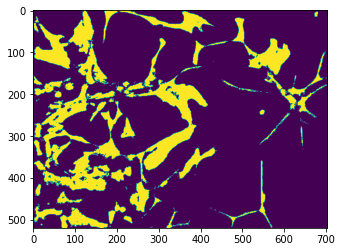

In [13]:
plt.imshow(predicted)

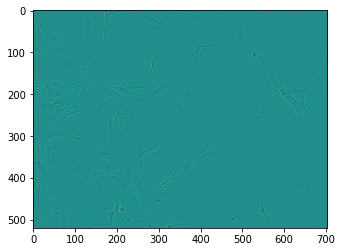

In [14]:
plt.imshow(image[0, 0])

d8bfd1dafdc4


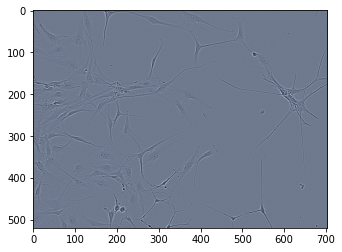

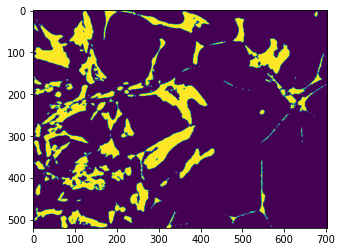

d48ec7815252


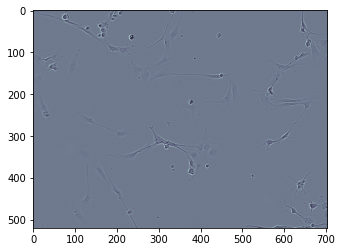

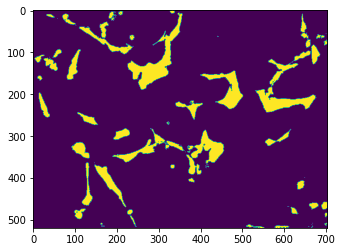

7ae19de7bc2a


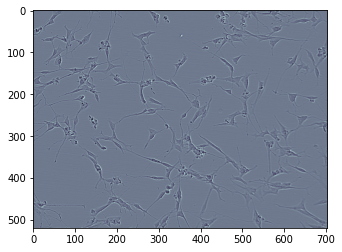

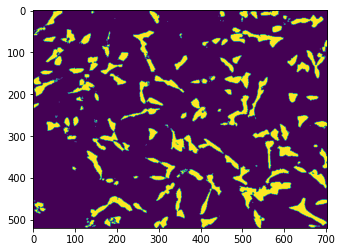

In [29]:
submission = list()
for i, batch in enumerate(dl_test):
    image = batch["image"]
    predicted = model(image.float())
    predicted = predicted.detach().numpy()[:, 0]
    i = 0
    for image_id, probability_mask in zip(batch["id"], predicted):
        predictions = []
        pred_mask = cv2.threshold(probability_mask, 0.7, 1, cv2.THRESH_BINARY)[1]
        num_component, component = cv2.connectedComponents(pred_mask.astype(np.uint8))
        for c in range(1, num_component):
            p = (component == c)
            if p.sum() > 300:
                a_prediction = np.zeros((520, 704), np.float32)
                a_prediction[p] = 1
                predictions.append(a_prediction)
        for prediction in predictions:
            submission.append((image_id, rle_encoding(prediction)))
        
        image_ids = [image_id for image_id, preds in submission]
        if image_id not in image_ids:
            submission.append((image_id, ""))

        print(image_id)
        plt.imshow(image[0, i], cmap="bone")
        plt.show()
        i += 1
        plt.imshow(pred_mask)
        plt.show()

In [19]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [66]:
df_submission = pd.DataFrame(submission, columns=['id', 'predicted'])

In [67]:
df_submission

,id,predicted
0,d8bfd1dafdc4,120 1 122 6 825 1 827 5 1531 4 2234 6 2935 11 ...
1,d8bfd1dafdc4,173 2 176 1 178 5 184 1 192 1 194 39 876 62 15...
2,d8bfd1dafdc4,13161 5 13861 13 14563 20 15267 22 15971 22 16...
3,d8bfd1dafdc4,47473 5 48175 8 48879 10 49583 10 50287 11 509...
4,d8bfd1dafdc4,51782 2 52485 4 53189 5 53894 5 54598 6 55302 ...
...,...,...
99,7ae19de7bc2a,335632 4 336336 5 337040 6 337744 6 338448 7 3...
100,7ae19de7bc2a,343294 2 343997 4 344699 1 344701 3 345402 6 3...
101,7ae19de7bc2a,345870 1 346568 10 347269 14 347963 1 347965 2...
102,7ae19de7bc2a,346687 4 347387 1 347389 7 348090 10 348793 11...


In [61]:
df_submission.id.unique()

array(['d8bfd1dafdc4', 'd48ec7815252', '7ae19de7bc2a'], dtype=object)

In [68]:
def check_is_run_length(mask_rle):
    if not mask_rle:
        return True
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    start_prev = starts[0]
    ok = True
    for start in starts[1:]:
        ok = ok and start > start_prev
        start_prev = start
        if not ok:
            return False
    return True

In [69]:
if df_submission['predicted'].apply(check_is_run_length).mean() != 1:
    print("Check run lenght failed")
    create_empty_submission()